In [1]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    !pip3 install -Uq torch torchvision torchaudio
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.0
torchvision version: 0.15.1


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Read And Split Data

In [4]:
import os
import shutil
import random

# Set the seed for reproducibility
random.seed(42)

# Define the ratios for train, validation, and test
train_ratio = 0.9
val_ratio = 0.05
test_ratio = 0.05

# Create destination folders
output_root = '/kaggle/working/data'
train_dest_path = os.path.join(output_root, 'train')
val_dest_path = os.path.join(output_root, 'validation')
test_dest_path = os.path.join(output_root, 'test')

for folder in [train_dest_path, val_dest_path, test_dest_path]:
    os.makedirs(os.path.join(folder, 'benign'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'malignant'), exist_ok=True)

# Function to move files from source to destination
def move_files(file_list, source_folder, dest_benign_folder, dest_malignant_folder):
    for filename in file_list:
        source_path = os.path.join(source_folder, filename)
        dest_benign_path = os.path.join(dest_benign_folder, filename)
        dest_malignant_path = os.path.join(dest_malignant_folder, filename)
        shutil.copy(source_path, dest_benign_path)
        shutil.copy(source_path, dest_malignant_path)

# List all files in benign and malignant folders
benign_files = os.listdir('/kaggle/input/skin-cancer/melanoma_cancer_dataset/train/benign')
malignant_files = os.listdir('/kaggle/input/skin-cancer/melanoma_cancer_dataset/train/malignant')

# Shuffle the files for randomness
random.shuffle(benign_files)
random.shuffle(malignant_files)

# Calculate the number of files for each split
num_train_benign = int(train_ratio * len(benign_files))
num_val_benign = int(val_ratio * len(benign_files))
num_test_benign = len(benign_files) - num_train_benign - num_val_benign

num_train_malignant = int(train_ratio * len(malignant_files))
num_val_malignant = int(val_ratio * len(malignant_files))
num_test_malignant = len(malignant_files) - num_train_malignant - num_val_malignant

# Move files to the respective folders
move_files(benign_files[:num_train_benign], '/kaggle/input/skin-cancer/melanoma_cancer_dataset/train/benign', train_dest_path+'/benign', train_dest_path+'/benign')
move_files(benign_files[num_train_benign:num_train_benign + num_val_benign], '/kaggle/input/skin-cancer/melanoma_cancer_dataset/train/benign', val_dest_path+'/benign', val_dest_path+'/benign')
move_files(benign_files[-num_test_benign:], '/kaggle/input/skin-cancer/melanoma_cancer_dataset/train/benign', test_dest_path+'/benign', test_dest_path+'/benign')

move_files(malignant_files[:num_train_malignant], '/kaggle/input/skin-cancer/melanoma_cancer_dataset/train/malignant', train_dest_path+'/malignant', train_dest_path+'/malignant')
move_files(malignant_files[num_train_malignant:num_train_malignant + num_val_malignant], '/kaggle/input/skin-cancer/melanoma_cancer_dataset/train/malignant', val_dest_path+'/malignant', val_dest_path+'/malignant')
move_files(malignant_files[-num_test_malignant:], '/kaggle/input/skin-cancer/melanoma_cancer_dataset/train/malignant', test_dest_path+'/malignant', test_dest_path+'/malignant')

# Print the number of files in each split
print(f"Number of training samples: {len(os.listdir(train_dest_path+'/benign')) + len(os.listdir(train_dest_path+'/malignant'))}")
print(f"Number of validation samples: {len(os.listdir(val_dest_path+'/benign')) + len(os.listdir(val_dest_path+'/malignant'))}")
print(f"Number of test samples: {len(os.listdir(test_dest_path+'/benign')) + len(os.listdir(test_dest_path+'/malignant'))}")


Number of training samples: 9544
Number of validation samples: 530
Number of test samples: 531


# Create dataloaders and Data Augmentation

In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    return mean, std

def create_dataloaders(
    train_dir: str,
    validation_dir: str,
    test_dir: str,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # Define data augmentation transforms for the training set
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ])

    # Common transform for validation and test sets
    common_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

    # Use ImageFolder to create datasets with appropriate transforms
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    validation_data = datasets.ImageFolder(validation_dir, transform=common_transform)
    test_data = datasets.ImageFolder(test_dir, transform=common_transform)

    # Get class names
    class_names = train_data.classes

    # Calculate mean and std for the training set
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    mean, std = calculate_mean_std(train_loader)

    # Add normalization to the transforms
    train_transform.transforms.append(transforms.Normalize(mean=mean, std=std))
    common_transform.transforms.append(transforms.Normalize(mean=mean, std=std))

    # Update the transforms in datasets
    train_data.transform = train_transform
    validation_data.transform = common_transform
    test_data.transform = common_transform


    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    validation_dataloader = DataLoader(
        validation_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_dataloader, validation_dataloader, test_dataloader, class_names, mean, std


In [6]:
train_dataloader, val_dataloader, test_dataloader, class_names, mean, std = create_dataloaders(
    train_dir=train_dest_path,
    validation_dir=val_dest_path,
    test_dir=test_dest_path,
    batch_size=32,
    num_workers=NUM_WORKERS
)

train_dataloader, val_dataloader, test_dataloader, class_names, mean, std

(<torch.utils.data.dataloader.DataLoader at 0x79f6d3923fa0>,
 ['benign', 'malignant'],
 tensor([0.6850, 0.5705, 0.5486]),
 tensor([0.1714, 0.1661, 0.1692]))

# Model

## Get pretrained model - EfficientNet B0

In [7]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)  # Remove 'check_hash' if present, otherwise do nothing
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

weights = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model = efficientnet_b0(weights="DEFAULT")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 75.2MB/s]


## Freeze Or Unfreeze
False = Freeze

True = Unfreeze

In [8]:
for param in model.features.parameters():
    param.requires_grad = True

In [9]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [10]:
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## LossFN and OptimizeFN

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), rho=0.9, eps=1e-6)

## Early Stopping

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)

## Training Code

In [13]:
from torch.optim.lr_scheduler import CosineAnnealingLR

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            val_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          early_stopping: EarlyStopping = None) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
    }

    # Make sure model on target device
    model.to(device)

    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        val_loss, val_acc = val_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        # Adjust the learning rate using the scheduler
        scheduler.step()
        
        # Print out what's happening
        print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"val_loss: {val_loss:.4f} | "
        f"val_acc: {val_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping.")
                break


    # Return the filled results at the end of the epochs
    return results

## Evaluate Code

In [14]:
from typing import Tuple
from tqdm import tqdm

def evaluate(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device) -> Tuple[float, float, float]:
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation during evaluation
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Accumulate total loss
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Collect labels and predictions for recall calculation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss, accuracy, and recall
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples

    return accuracy, average_loss


# Start Training

In [15]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
early_stopping = EarlyStopping(patience=2, delta=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device,
                       early_stopping=early_stopping)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:41<06:12, 41.38s/it]

Epoch: 1 | train_loss: 0.3762 | train_acc: 0.8329 | val_loss: 0.2966 | val_acc: 0.8723


 20%|██        | 2/10 [01:21<05:25, 40.72s/it]

Epoch: 2 | train_loss: 0.3141 | train_acc: 0.8670 | val_loss: 0.3305 | val_acc: 0.8627


 30%|███       | 3/10 [02:01<04:43, 40.50s/it]

Epoch: 3 | train_loss: 0.2865 | train_acc: 0.8792 | val_loss: 0.2337 | val_acc: 0.8926


 40%|████      | 4/10 [02:41<04:00, 40.08s/it]

Epoch: 4 | train_loss: 0.2711 | train_acc: 0.8867 | val_loss: 0.2238 | val_acc: 0.9116


 50%|█████     | 5/10 [03:20<03:18, 39.80s/it]

Epoch: 5 | train_loss: 0.2502 | train_acc: 0.8983 | val_loss: 0.2019 | val_acc: 0.9122


 60%|██████    | 6/10 [04:00<02:38, 39.72s/it]

Epoch: 6 | train_loss: 0.2315 | train_acc: 0.9002 | val_loss: 0.1997 | val_acc: 0.9134


 70%|███████   | 7/10 [04:39<01:59, 39.69s/it]

Epoch: 7 | train_loss: 0.2129 | train_acc: 0.9125 | val_loss: 0.1750 | val_acc: 0.9226


 80%|████████  | 8/10 [05:19<01:19, 39.56s/it]

Epoch: 8 | train_loss: 0.1990 | train_acc: 0.9170 | val_loss: 0.1937 | val_acc: 0.9208


 80%|████████  | 8/10 [05:58<01:29, 44.78s/it]

Epoch: 9 | train_loss: 0.1895 | train_acc: 0.9227 | val_loss: 0.1796 | val_acc: 0.9134
Early stopping.
[INFO] Total training time: 358.284 seconds


## Plot the progress

In [16]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

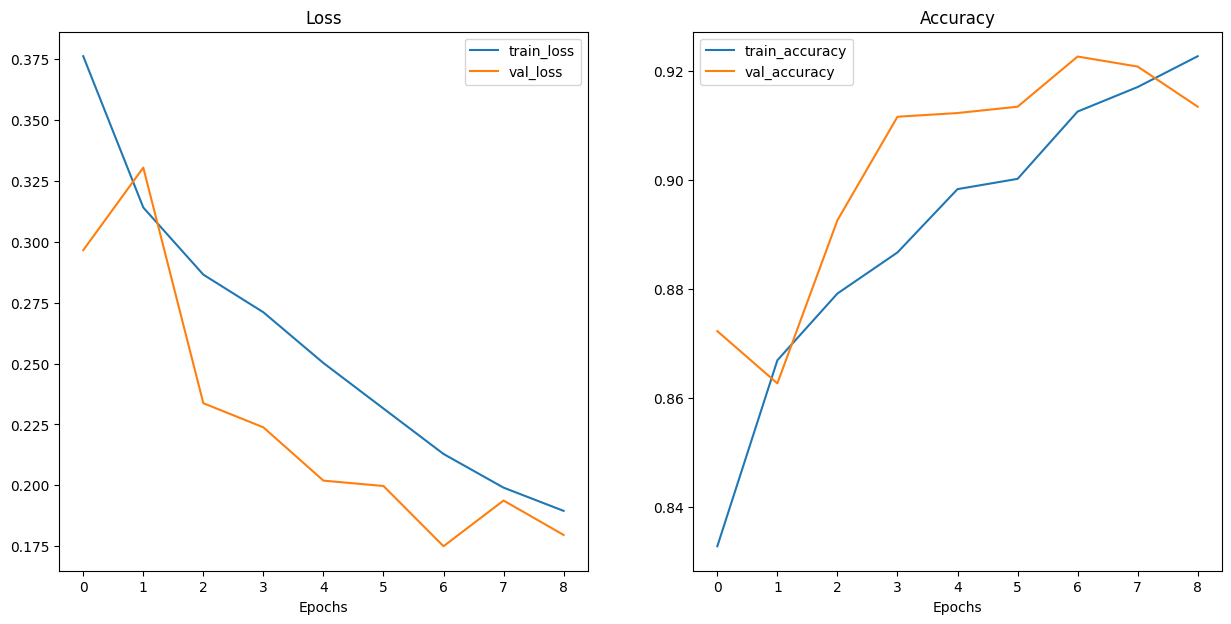

In [17]:
# Plot the loss curves of our model
plot_loss_curves(results)

# Predict

In [18]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

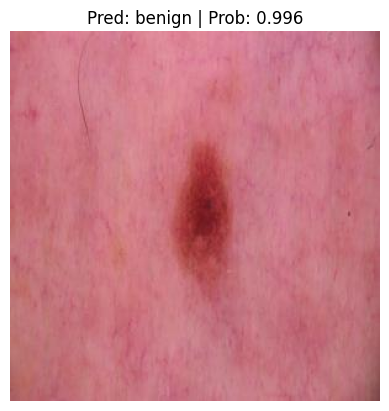

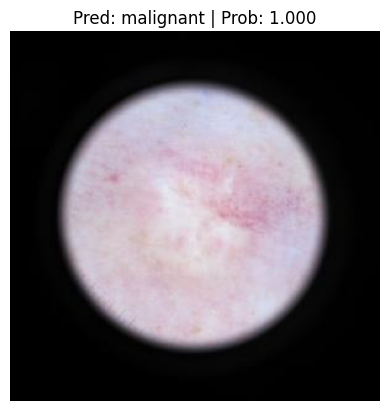

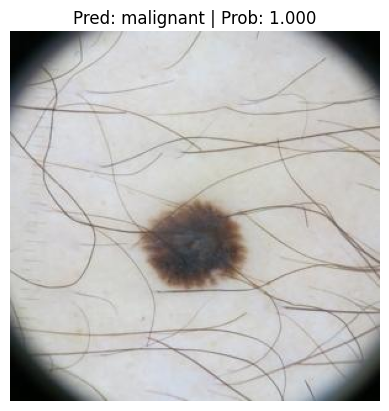

In [19]:
# Get a random list of image paths from test set
import random
from pathlib import Path
num_images_to_plot = 3
test_image_path_list = list(Path(test_dest_path).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

# Performance on test data

In [20]:
test_accuracy, test_loss = evaluate(model, test_dataloader, loss_fn, device)
print(f' Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}')

100%|██████████| 17/17 [00:00<00:00, 17.69it/s]

 Test Accuracy: 0.9190 | Test Loss: 0.1796
